In [10]:
import torch
import os
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-3B"
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [4]:
x = "can you book a table at johnys at six on friday"
inputs = tokenizer(x, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[128000,   4919,    499,   2363,    264,   2007,    520,  40742,   1065,
            520,   4848,    389,  80413]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
ffn_activations = {}

def get_activations(layer):
    """
    https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
    layer: layer identifier
    """
    def hook(module, input, output):
        """
        module: the layer/block where the hook is attached
        input: input to the layer/block
        output: output from the layer/block
        """
        ffn_activations[layer] = output.detach().cpu()
    return hook

In [ ]:
for layer_num, layer in enumerate(model.model.layers):
    layer.mlp.register_forward_hook(get_activations(layer_num)) # forward hook executes get_activations() after the layer-specific forward() call

In [ ]:
with torch.no_grad():
    output = model(**inputs) # forward pass

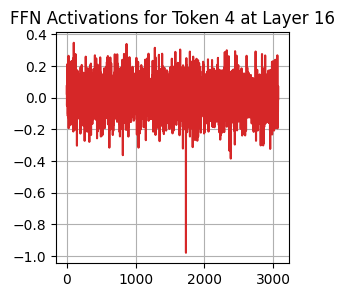

In [19]:
LAYER = 16
TOKEN = 4
plt.figure(figsize=(3,3))
plt.plot(ffn_activations[LAYER][0, TOKEN, :].numpy(), color='tab:red')
plt.title(f"FFN Activations for Token {TOKEN} at Layer {LAYER}")
plt.grid(True)
plt.show()